Video followed in this notebook: <br>
[The spelled-out intro to language modeling: building makemore](https://www.youtube.com/watch?v=PaCmpygFfXo&t=1343s)

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Table of Contents
- **[Reading data](#1)**
- **[Frequency map of letter combinations](#2)**
    - [Drafting the map](#2-1)
    - [Nicer looking map](#2-2)
    - [Char to int dicts](#2-3)
- **[A count-based bigram model for names generation](#3)**
    - [Switching to working with torch tensors](#3-1)
    - [Creating probabilities matrix](#3-2)

- **[Evaluating the model](#4)**

- **[A single layer perceptron bigram model for names generation](#5)**

    - [Creating the training set](#5-1)
    - [Working out forward pass](#5-2)
    - [Experimenting with loss and weights](#5-3)
    - [Backprop](#5-4)
    - [Full loop of training](#5-5)
    - [Sampling](#5-6)

<a name='1'></a>
# Reading data

In [2]:
data = open('names.txt', 'r').read()

In [3]:
words = data.split('\n')

In [4]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [5]:
len(words)

32033

In [6]:
#shortest word
min(map(len, words))

2

In [7]:
#longest word
max(map(len, words))

15

<a name='2'></a>
#  Frequency map of letter combinations

<a name='2-1'></a>
## Drafting the map

In [29]:
b = {}
for w in words:
    chs = ['<S>'] + list(w) + ['<E>']
    for ch1, ch2 in zip(chs, chs[1:]):
        bigram = (ch1, ch2)
        b[bigram] = b.get(bigram, 0) + 1
#         print(ch1, ch2)

In [9]:
sorted(b.items(), key = lambda x: -x[1], )

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('<S>', 'k'), 2963),
 (('l', 'e'), 2921),
 (('e', 'n'), 2675),
 (('l', 'a'), 2623),
 (('m', 'a'), 2590),
 (('<S>', 'm'), 2538),
 (('a', 'l'), 2528),
 (('i', '<E>'), 2489),
 (('l', 'i'), 2480),
 (('i', 'a'), 2445),
 (('<S>', 'j'), 2422),
 (('o', 'n'), 2411),
 (('h', '<E>'), 2409),
 (('r', 'a'), 2356),
 (('a', 'h'), 2332),
 (('h', 'a'), 2244),
 (('y', 'a'), 2143),
 (('i', 'n'), 2126),
 (('<S>', 's'), 2055),
 (('a', 'y'), 2050),
 (('y', '<E>'), 2007),
 (('e', 'r'), 1958),
 (('n', 'n'), 1906),
 (('y', 'n'), 1826),
 (('k', 'a'), 1731),
 (('n', 'i'), 1725),
 (('r', 'e'), 1697),
 (('<S>', 'd'), 1690),
 (('i', 'e'), 1653),
 (('a', 'i'), 1650),
 (('<S>', 'r'), 1639),
 (('a', 'm'), 1634),
 (('l', 'y'), 1588),
 (('<S>', 'l'), 1572),
 (('<S>', 'c'), 1542),
 (('<S>', 'e'), 1531),
 (('j', 'a'), 1473),
 (

In [30]:
# pivot table where frequency (within initial list of names) of each char followed by any other char is shown. 
# this variant includes <S> and <E> tokens

def create_pivot(b):
    interim = pd.DataFrame(b.items())
    interim[['letter_1', 'letter_2']] = pd.DataFrame(interim[0].to_list())
    interim = interim.drop([0], axis=1)

    res_pivot = interim.pivot_table(index = 'letter_1', 
                        columns = 'letter_2').fillna(0)
    res_pivot.columns = res_pivot.columns.to_flat_index()
    res_pivot.columns = list(map(lambda x: x[1], res_pivot.columns))
    return res_pivot.astype('int32')

res_pivot = create_pivot(b)

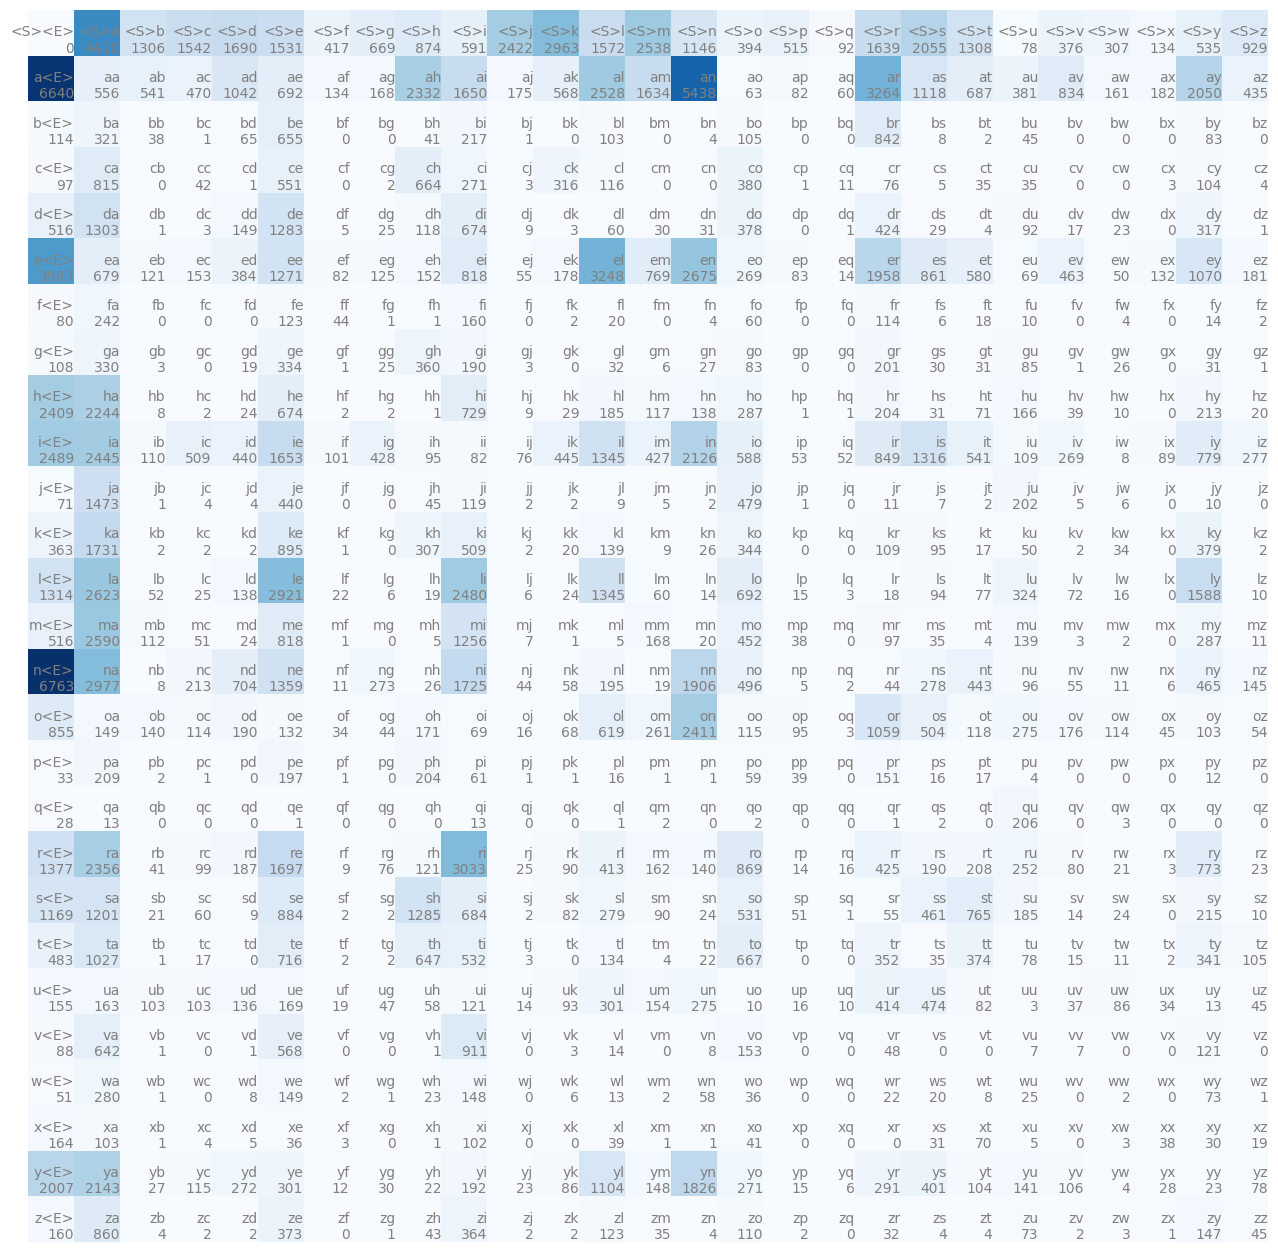

In [31]:
def draw_map(res_pivot):
    plt.figure(figsize=(16,16))
    sns.heatmap(res_pivot, cmap='Blues', cbar=False)
    plt.axis('off');

    for i in range(len(list(res_pivot.columns))):
        for j in range(len(list(res_pivot.index))):
            chstr_letters = list(res_pivot.index)[j] + list(res_pivot.columns)[i]
            chstr_freq = res_pivot.loc[list(res_pivot.index)[j], list(res_pivot.columns)[i]]
            txt = chstr_letters + '\n' + str(chstr_freq)
            plt.text(i+1, j+1, txt, ha="right", va="bottom", color='gray')

draw_map(res_pivot)

<a name='2-2'></a>
## Nicer looking map

In [32]:
#Replacing 2 special tokens for begining and end with one -- '.'

b = {}
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        bigram = (ch1, ch2)
        b[bigram] = b.get(bigram, 0) + 1
#         print(ch1, ch2)

In [33]:
nicer_pivot = create_pivot(b)

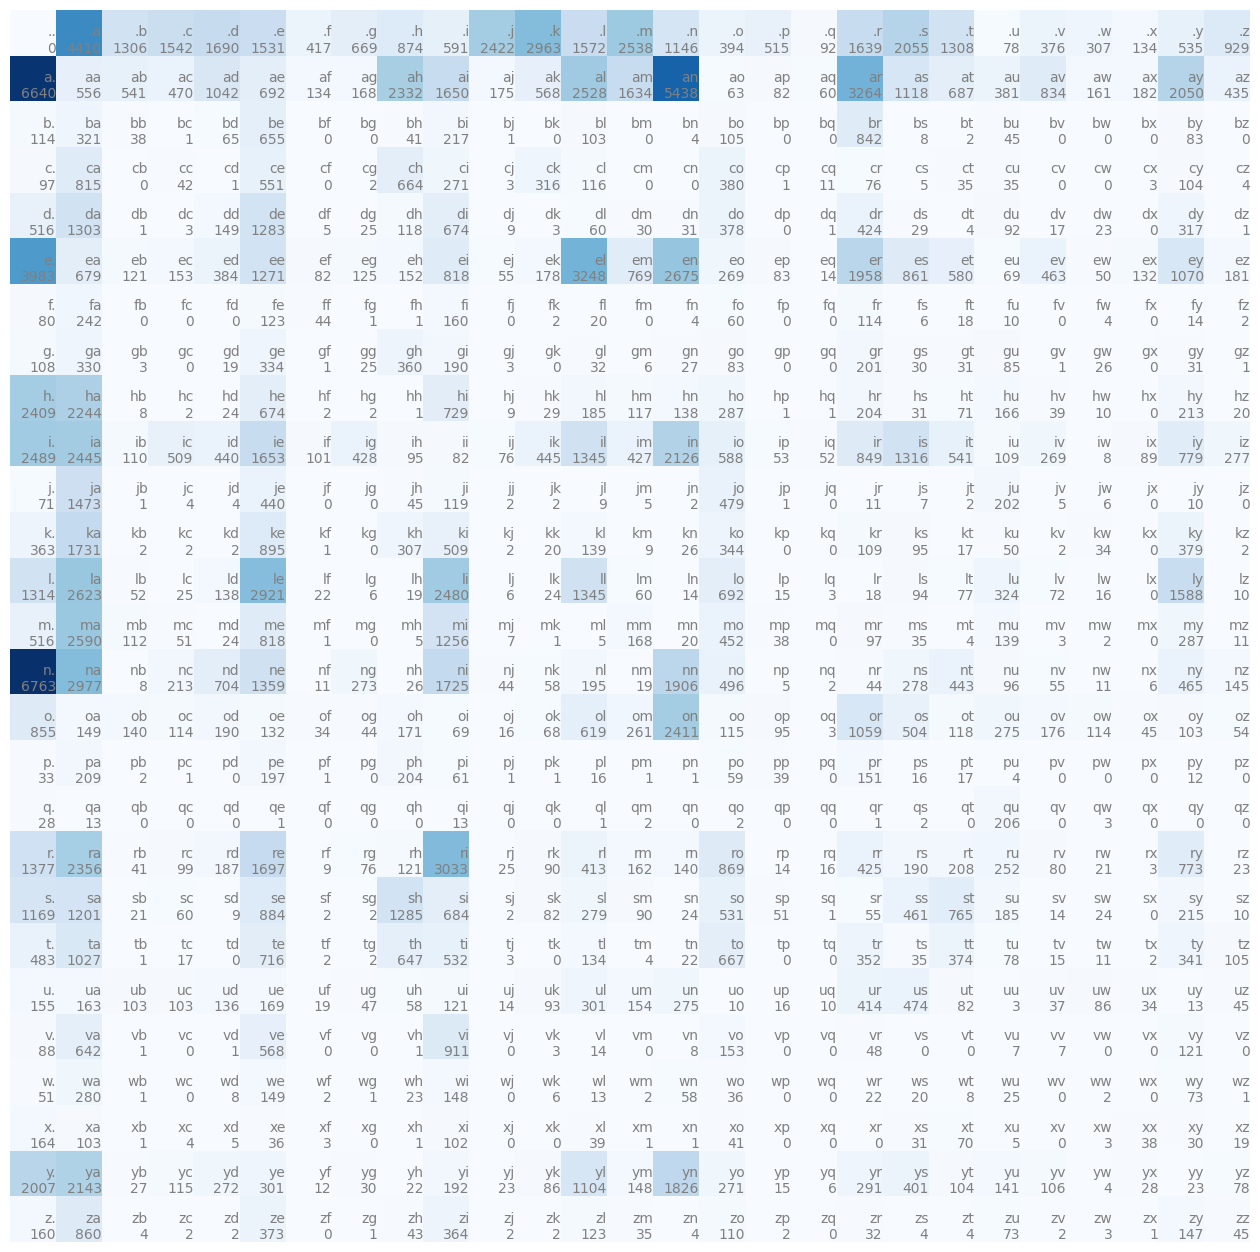

In [34]:
draw_map(nicer_pivot)

<a name='2-3'></a>
## Char to int dicts

In [244]:
chars = sorted(list(set(data)))[1:]
chars = ['.'] + chars

stoi = {s:i for i,s in enumerate(chars)}
# stoi['.'] = 0

itos = {i:s for s,i in stoi.items()}

<a name='3'></a>
# Building a count-based bigram model for names generation

<a name='3-1'></a>
## Switching to working with torch tensors

In [35]:
N = torch.tensor(nicer_pivot.values)

In [36]:
N[0, :] # first row of the map above

tensor([   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
        1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
         134,  535,  929], dtype=torch.int32)

In [37]:
N[0]

tensor([   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
        1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
         134,  535,  929], dtype=torch.int32)

In [40]:
# creating probability of any char to be the first char of a name

p = N[0].float()
p = p / p.sum()
p

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

In [74]:
#sampling an index of a char from distribution with fixed seed
fixed_gen = torch.Generator().manual_seed(331223)
ix = torch.multinomial(p, num_samples=1, replacement=True, generator=fixed_gen).item()
ix

4

In [75]:
# translating index to char 
itos[ix]

'd'

In [106]:
fixed_gen = torch.Generator().manual_seed(321123)

def generate_name(num_names):
    '''
    Here we start with first row because it contains first letters of names, 
    sample a letter (or collumn), 
    this letter gives us the number or a row to sample next from.
    This is repeated until the end token is sampled.
    '''
    
    out = []
    for cnt in range(num_names):
        this_name = []
        ix=0 #ix of the start token '.'
        while True:

            p = N[ix].float()
            p = p / p.sum()

            ix = torch.multinomial(p, num_samples=1, replacement=True, generator=fixed_gen).item()
            this_name.append(itos[ix])
            if ix == 0:
                 break
        out.append(''.join(this_name)[:-1])
    return out
generate_name(10)

['helobhayuioaazlsishark',
 'mriowanslely',
 'ch',
 'annelyan',
 'fa',
 'ayllevellahi',
 'h',
 'jeronno',
 's',
 'on']

<a name='3-2'></a>
## Creating probabilities matrix

In [134]:
N.sum(dim=1, keepdims=True).shape

torch.Size([27, 1])

In [137]:
N.sum(dim=1, keepdims=True)

tensor([[32033],
        [33885],
        [ 2645],
        [ 3532],
        [ 5496],
        [20423],
        [  905],
        [ 1927],
        [ 7616],
        [17701],
        [ 2900],
        [ 5040],
        [13958],
        [ 6642],
        [18327],
        [ 7934],
        [ 1026],
        [  272],
        [12700],
        [ 8106],
        [ 5570],
        [ 3135],
        [ 2573],
        [  929],
        [  697],
        [ 9776],
        [ 2398]])

In [135]:
P = N/N.sum(dim=1, keepdims=True)

(0.0, 27.0, 27.0, 0.0)

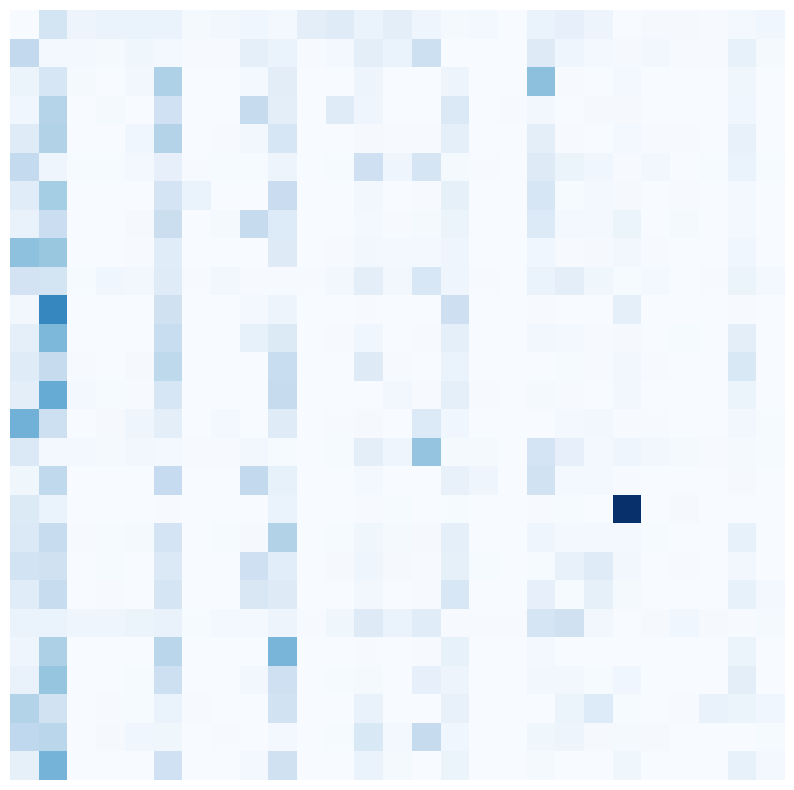

In [136]:
plt.figure(figsize=(10,10))
sns.heatmap(P, cmap='Blues', cbar=False)
plt.axis('off')

In [144]:
fixed_gen = torch.Generator().manual_seed(321123)

def ef_generate_name(num_names, P):
    '''
    Same as generate_name func but using the probabilities matrix P 
    instead of normalising every row in the loop
    '''

    out = []
    for cnt in range(num_names):
        this_name = []
        ix=0                       # ix of the start token '.'
        while True:
            ix = torch.multinomial(P[ix], num_samples=1, replacement=True, generator=fixed_gen).item()
            this_name.append(itos[ix])
            if ix == 0:
                 break
        out.append(''.join(this_name)[:-1])
    return out

ef_generate_name(10, P)

['helobhayuioaazlsishark',
 'mriowanslely',
 'ch',
 'annelyan',
 'fa',
 'ayllevellahi',
 'h',
 'jeronno',
 's',
 'on']

<a name='4'></a>
# Evaluating the model

In [167]:
"""
Printing model probabilites for true bigrams form the dataset. Some are as high as 40%.
"""
for w in words[:5]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        print(f'{ch1}{ch2}: {prob*100: .1f}%')

.e:  4.8%
em:  3.8%
mm:  2.5%
ma:  39.0%
a.:  19.6%
.o:  1.2%
ol:  7.8%
li:  17.8%
iv:  1.5%
vi:  35.4%
ia:  13.8%
a.:  19.6%
.a:  13.8%
av:  2.5%
va:  25.0%
a.:  19.6%
.i:  1.8%
is:  7.4%
sa:  14.8%
ab:  1.6%
be:  24.8%
el:  15.9%
ll:  9.6%
la:  18.8%
a.:  19.6%
.s:  6.4%
so:  6.6%
op:  1.2%
ph:  19.9%
hi:  9.6%
ia:  13.8%
a.:  19.6%


To build the best model we need to find best model parameters. 
In order to optimise parameters we seek to predict in a way that all predictions are distributed as close 
to the mean as possible. In this case the total probability of the data is maximised. 
Hence, we can evaluate the model by finding the total probability of the predictions, 
i.e. multiplying the probabilities the model predicted for the true values.
Assumption is that labels are distributed normaly. <br>
[Probability concepts explained: Maximum likelihood estimation](https://towardsdatascience.com/probability-concepts-explained-maximum-likelihood-estimation-c7b4342fdbb1).



In [185]:
# finding likelihood
res_prob = 1
for cnt, w in enumerate(words):
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        if P[ix1, ix2].item()>0:
            res_prob *= P[ix1, ix2].item()
        else:
            continue
    if cnt % int(len(words)/10)==0:
        print(f'Word count: {cnt}, Prob: {res_prob}')

Word count: 0, Prob: 3.478213834606263e-06
Word count: 3203, Prob: 0.0
Word count: 6406, Prob: 0.0
Word count: 9609, Prob: 0.0
Word count: 12812, Prob: 0.0
Word count: 16015, Prob: 0.0
Word count: 19218, Prob: 0.0
Word count: 22421, Prob: 0.0
Word count: 25624, Prob: 0.0
Word count: 28827, Prob: 0.0
Word count: 32030, Prob: 0.0


Because the numbers are so small, and probability nullifies very quickly, log-likelyhood is used instead.
The sign is inverted to be able to minimise it at later steps

In [201]:
log_like = 0
for w in words[:3]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        logprob = -torch.log(P[ix1, ix2])
        log_like += logprob
        print(f'{ch1}{ch2}: {prob*100: .1f}%, {logprob: .1f}')
print(f'\nlog likelihood: {log_like.item(): .1f}' )

.e:  4.8%,  3.0
em:  3.8%,  3.3
mm:  2.5%,  3.7
ma:  39.0%,  0.9
a.:  19.6%,  1.6
.o:  1.2%,  4.4
ol:  7.8%,  2.6
li:  17.8%,  1.7
iv:  1.5%,  4.2
vi:  35.4%,  1.0
ia:  13.8%,  2.0
a.:  19.6%,  1.6
.a:  13.8%,  2.0
av:  2.5%,  3.7
va:  25.0%,  1.4
a.:  19.6%,  1.6

log likelihood:  38.8


In [209]:
# finding log likelihood of the model
res_log_prob = 0
n=0
for cnt, w in enumerate(words):
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        res_log_prob += -torch.log(P[ix1, ix2]).item()
        n+=1
    if cnt % int(len(words)/10)==0:
        print(f'Word count: {cnt}, Negative log likelihood: {res_log_prob: 0.2f}')
print(f'\nAverage nll: {res_log_prob / n: .2f}')

Word count: 0, Negative log likelihood:  12.57
Word count: 3203, Negative log likelihood:  53034.86
Word count: 6406, Negative log likelihood:  107262.15
Word count: 9609, Negative log likelihood:  162513.57
Word count: 12812, Negative log likelihood:  218775.21
Word count: 16015, Negative log likelihood:  275984.27
Word count: 19218, Negative log likelihood:  332325.09
Word count: 22421, Negative log likelihood:  387228.27
Word count: 25624, Negative log likelihood:  443805.55
Word count: 28827, Negative log likelihood:  501629.25
Word count: 32030, Negative log likelihood:  559834.51

Average nll:  2.45


Perfect model's loglikelihood result would be close to zero, but here it's over 55k. Future steps will be directed at building the model and finding model parameters that minimises this evaluation result. Equivalent to minimising average loglikelihood (for smaller more managable numbers). <br><br>It case of the current model, the model parameters are the counted probabilites in the matrix P. Further these parameters will the weights of an NN.

In [292]:
# checking nll of my name
res_log_prob = 0
n=0
for w in ["igor"]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        res_log_prob += -torch.log(P[ix1, ix2]).item()
        n+=1
        
        print(f'{ch1}{ch2}: {res_log_prob: .2f}')
print(f'\nAverage nll: {res_log_prob / n: .2f}')

.i:  3.99
ig:  7.71
go:  10.86
or:  12.87
r.:  15.10

Average nll:  3.02


<a name='5'></a>
# A single layer perceptron bigram model for names generation

We will use MLP to predict probabilities of a next letter. We will use gradient based optimisation to tune the parameters of the model to minimise negative loglikelihood of the model.

In [234]:
import torch.nn.functional as F

<a name='5-1'></a>
## Creating the training set

In [325]:
def create_train(num_words):
    xs, ys = [], []

    for cnt, w in enumerate(words[:num_words]):
        chs = ['.'] + list(w) + ['.']
        for ch1, ch2 in zip(chs, chs[1:]):
            ix1 = stoi[ch1]
            ix2 = stoi[ch2]
            xs.append(ix1)
            ys.append(ix2)
    xs, ys = torch.tensor(xs), torch.tensor(ys)
    
    return {'xs': xs, 'ys': ys}
train_dict = create_train(1)
xs, ys = train_dict['xs'], train_dict['ys']

In [231]:
xs

tensor([ 0,  5, 13, 13,  1])

In [232]:
ys

tensor([ 5, 13, 13,  1,  0])

In [255]:
xenc = F.one_hot(xs, num_classes=len(chars)).float() # input of the NN, encoded into 1s and 0s
xenc

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])

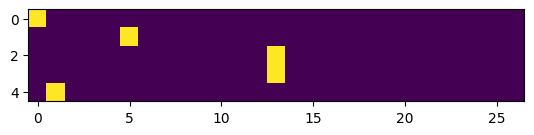

In [256]:
plt.imshow(xenc)

In [258]:
xenc.dtype # need to make sure the type here is float to be able to use as input into MLP

torch.float32

<a name='5-2'></a>
## Working out forward pass

In [261]:
# initial weights randomly initialised
W = torch.randn((len(chars), 1))
W

tensor([[ 0.5790],
        [-0.1798],
        [ 0.2284],
        [-1.2448],
        [-1.9185],
        [-0.1702],
        [-1.3188],
        [ 0.7441],
        [-0.9114],
        [-0.2036],
        [-0.6602],
        [ 2.0149],
        [ 0.9686],
        [-1.3901],
        [ 0.4327],
        [-1.4093],
        [ 0.5858],
        [ 0.1760],
        [-0.1546],
        [-0.5946],
        [-0.4649],
        [ 0.3935],
        [ 0.0209],
        [ 1.8252],
        [-0.4973],
        [ 0.1890],
        [-0.1272]])

In [268]:
# output of a linear activation of a single neuron without a bias
xenc @ W 

tensor([[ 0.5790],
        [-0.1702],
        [-1.3901],
        [-1.3901],
        [-0.1798]])

In [269]:
# increasing number of neurons to the number of characters.
W = torch.randn((len(chars), len(chars)))

# output of a linear activation of 27 neurons without a bias
xenc @ W 

tensor([[ 7.0460e-01, -9.0726e-01,  4.1443e-01, -3.2612e-01,  1.8848e+00,
          2.0881e+00,  1.0815e-01,  2.4869e-01,  1.3721e-01,  1.3909e+00,
         -2.5000e-01,  1.2253e+00, -1.5436e+00, -5.0519e-01, -6.1913e-02,
          4.0005e-01, -5.7947e-01,  4.6387e-01,  1.1930e+00,  6.7284e-01,
          6.7893e-01, -7.3222e-01, -1.0207e+00,  1.2969e+00,  7.0791e-01,
          1.2317e+00,  2.1262e-02],
        [-1.4654e+00, -2.0291e-01, -6.7019e-01, -1.3802e+00,  6.7644e-01,
          2.3543e-04,  6.2696e-01, -6.5852e-01,  1.2277e+00,  2.9693e-01,
          3.9885e-02, -1.3770e-01,  3.6795e-01, -7.8294e-01,  1.4323e+00,
          2.3469e-01,  1.7014e+00, -4.0970e-01, -5.4968e-01, -1.1285e-01,
          2.1963e+00, -1.3682e-01,  2.1082e-01, -4.4551e-02,  5.7008e-01,
          9.3502e-02, -4.9552e-02],
        [-1.4403e-01, -4.1668e-01, -8.8452e-01, -6.6496e-01, -1.4232e+00,
         -9.0387e-01, -1.7760e+00, -1.8395e+00, -6.1955e-01, -8.3071e-01,
         -1.5088e+00,  2.1085e-01, -1.22

In [270]:
(xenc @ W).shape

torch.Size([5, 27])

The output is neither probs nor counts. We interpret them as log counts or logits. 
We need to transform them to probabilities. To do that we inverse the log operation, 
i.e. find the exponent of the output element wise and then normalise them so that they sum to 1.

In [281]:
logits = (xenc @ W) # log-counts
counts = logits.exp() # elementwise exponent to find counts
probs = counts / counts.sum(1, keepdims=True) # normalizing by calculating softmax

In [282]:
probs

tensor([[0.0370, 0.0074, 0.0277, 0.0132, 0.1205, 0.1476, 0.0204, 0.0235, 0.0210,
         0.0735, 0.0142, 0.0623, 0.0039, 0.0110, 0.0172, 0.0273, 0.0102, 0.0291,
         0.0603, 0.0358, 0.0361, 0.0088, 0.0066, 0.0669, 0.0371, 0.0627, 0.0187],
        [0.0052, 0.0183, 0.0115, 0.0056, 0.0440, 0.0224, 0.0419, 0.0116, 0.0764,
         0.0301, 0.0233, 0.0195, 0.0323, 0.0102, 0.0937, 0.0283, 0.1227, 0.0149,
         0.0129, 0.0200, 0.2012, 0.0195, 0.0276, 0.0214, 0.0396, 0.0246, 0.0213],
        [0.0402, 0.0306, 0.0192, 0.0239, 0.0112, 0.0188, 0.0079, 0.0074, 0.0250,
         0.0202, 0.0103, 0.0573, 0.0411, 0.0368, 0.0463, 0.0152, 0.1037, 0.0191,
         0.0397, 0.0435, 0.0160, 0.0616, 0.0167, 0.1629, 0.0163, 0.0769, 0.0323],
        [0.0402, 0.0306, 0.0192, 0.0239, 0.0112, 0.0188, 0.0079, 0.0074, 0.0250,
         0.0202, 0.0103, 0.0573, 0.0411, 0.0368, 0.0463, 0.0152, 0.1037, 0.0191,
         0.0397, 0.0435, 0.0160, 0.0616, 0.0167, 0.1629, 0.0163, 0.0769, 0.0323],
        [0.0241, 0.0113,

In [283]:
probs[0].sum()

tensor(1.)

In [284]:
probs.shape

torch.Size([5, 27])

<a name='5-3'></a>
## Experimenting with loss and weights

There were 5 imput examples. Now for each of them we have a row of probabilities for each possible output letter.
These probabilities are random, since the model params (weights W) are random. We now need to find params W so that model predicts better probabilities, i.e. nll is lower.

In [290]:
"""
Here we iterate through bigrams of the first word, take the prediction of the NN, 
compare it to the label and calculate nll
"""

nlls = torch.zeros(5)
for i in range(5):
    # i-th bigram:
    x = xs[i].item() # input character index
    y = ys[i].item() # label character index
    print('-'*50)
    print('\n')
    print(f'bigram example {i+1}: {itos[x]}{itos[y]} (indexes {x},{y})')
    print('input to the neural net:', x)
    print('output probabilities from the neural net:', probs[i])
    print('label (actual next character):', y)
    p = probs[i, y]
    print('probability assigned by the net to the the correct character:', p.item())
    logp = torch.log(p)
    print('log likelihood:', logp.item())
    nll = -logp
    print('negative log likelihood:', nll.item())
    nlls[i] = nll

print('='*50+'\n')
print('average negative log likelihood, i.e. loss =', nlls.mean().item())

--------------------------------------------------


bigram example 1: .e (indexes 0,5)
input to the neural net: 0
output probabilities from the neural net: tensor([0.0370, 0.0074, 0.0277, 0.0132, 0.1205, 0.1476, 0.0204, 0.0235, 0.0210,
        0.0735, 0.0142, 0.0623, 0.0039, 0.0110, 0.0172, 0.0273, 0.0102, 0.0291,
        0.0603, 0.0358, 0.0361, 0.0088, 0.0066, 0.0669, 0.0371, 0.0627, 0.0187])
label (actual next character): 5
probability assigned by the net to the the correct character: 0.1476108431816101
log likelihood: -1.9131759405136108
negative log likelihood: 1.9131759405136108
--------------------------------------------------


bigram example 2: em (indexes 5,13)
input to the neural net: 5
output probabilities from the neural net: tensor([0.0052, 0.0183, 0.0115, 0.0056, 0.0440, 0.0224, 0.0419, 0.0116, 0.0764,
        0.0301, 0.0233, 0.0195, 0.0323, 0.0102, 0.0937, 0.0283, 0.1227, 0.0149,
        0.0129, 0.0200, 0.2012, 0.0195, 0.0276, 0.0214, 0.0396, 0.0246, 0.0213])
label (ac

We can see the nll is pretty high, we can try different initial W to get a lower loss.

In [300]:
all_nlls = []

for _ in range(500):
    # initialising the weights
    W = torch.randn((len(chars), len(chars)))

    #forward pass
    logits = (xenc @ W) # log-counts
    counts = logits.exp() # elementwise exponent to find counts
    probs = counts / counts.sum(1, keepdims=True) # normalizing by calculating softmax

    #evaluation
    nlls = torch.zeros(5)
    for i in range(5):
        # i-th bigram:
        x = xs[i].item() # input character index
        y = ys[i].item() # label character index
        p = probs[i, y]
        logp = torch.log(p)
        nll = -logp
        nlls[i] = nll
    
    all_nlls.append(nlls.mean().item())

In [301]:
sorted(all_nlls)[:5]

[2.676126003265381,
 2.6878440380096436,
 2.7265515327453613,
 2.737459659576416,
 2.739483118057251]

Randomly we wound weights that produced better nll. But instead of random attempts we will use gradient steps.
For that we will calculate loss as nll, differentiate it, corrent the weights in the direction of the gradient.

<a name='5-4'></a>
## Backprop

In [303]:
xs

tensor([ 0,  5, 13, 13,  1])

In [304]:
ys

tensor([ 5, 13, 13,  1,  0])

In [306]:
probs

tensor([[0.0482, 0.0279, 0.0119, 0.1951, 0.0050, 0.0211, 0.0613, 0.0080, 0.0160,
         0.0129, 0.0207, 0.0531, 0.0091, 0.0515, 0.0092, 0.0465, 0.0287, 0.0392,
         0.0244, 0.0671, 0.0677, 0.0098, 0.0435, 0.0891, 0.0036, 0.0190, 0.0100],
        [0.0423, 0.0170, 0.0885, 0.0209, 0.0432, 0.0091, 0.0132, 0.0839, 0.0116,
         0.0103, 0.0238, 0.0443, 0.0606, 0.0832, 0.0670, 0.0289, 0.0335, 0.0438,
         0.0769, 0.0261, 0.0117, 0.0084, 0.0360, 0.0614, 0.0198, 0.0149, 0.0197],
        [0.0138, 0.0138, 0.0238, 0.0034, 0.0075, 0.0083, 0.0354, 0.0069, 0.0077,
         0.0215, 0.0124, 0.2121, 0.0381, 0.0064, 0.0097, 0.0160, 0.0713, 0.0238,
         0.1230, 0.0189, 0.0147, 0.0275, 0.1132, 0.0814, 0.0670, 0.0180, 0.0043],
        [0.0138, 0.0138, 0.0238, 0.0034, 0.0075, 0.0083, 0.0354, 0.0069, 0.0077,
         0.0215, 0.0124, 0.2121, 0.0381, 0.0064, 0.0097, 0.0160, 0.0713, 0.0238,
         0.1230, 0.0189, 0.0147, 0.0275, 0.1132, 0.0814, 0.0670, 0.0180, 0.0043],
        [0.0135, 0.0733,

In [316]:
"""
To find the the log probabilities, we need to take the 
probabilities under indices ys from the prediction matrix.
E.g. from the first row we need to take probability under index 5
"""
probs[torch.arange(len(ys)), ys]

tensor([0.0211, 0.0832, 0.0064, 0.0138, 0.0135])

In [317]:
loss = -probs[torch.arange(len(ys)), ys].log().mean()
loss

tensor(3.9970)

In [327]:
long_train_dict = create_train(100) #len(words)
xs, ys = long_train_dict['xs'], long_train_dict['ys']


# initialising the weights
W = torch.randn((len(chars), len(chars)), requires_grad=True)

#forward pass
xenc = F.one_hot(xs, num_classes=len(chars)).float() # input of the NN, encoded into 1s and 0s
logits = (xenc @ W) # log-counts
counts = logits.exp() # elementwise exponent to find counts
probs = counts / counts.sum(1, keepdims=True) # normalizing by calculating softmax

#calc loss
loss = -probs[torch.arange(len(ys)), ys].log().mean()

#backward pass
W.grad = None # same as setting the gradient to zero
loss.backward()

In [330]:
loss.item()

3.8280179500579834

In [328]:
#once we've made backprop, gradient of W populated with values
W.grad

tensor([[ 2.5631e-03, -2.5519e-02, -2.1874e-03, -6.8928e-03, -1.0012e-03,
         -1.7152e-02,  1.5107e-03,  3.3847e-03, -4.5539e-03, -1.1331e-03,
         -1.7751e-03, -4.7020e-04, -3.9962e-03, -5.2005e-03, -4.1564e-03,
          4.4542e-04, -2.0967e-03,  4.9705e-03, -4.1300e-04, -1.3929e-02,
          4.0964e-03,  2.4915e-02,  3.1714e-02,  1.9741e-03,  5.3425e-03,
          4.1251e-03,  5.4347e-03],
        [-5.2598e-02,  1.0243e-04,  3.2782e-02,  2.3845e-03,  5.2793e-03,
          1.5054e-04,  1.9857e-02,  4.1311e-03, -7.3565e-03, -6.5200e-05,
          3.7032e-03,  4.7865e-03, -7.3547e-03,  3.3682e-03, -7.4309e-03,
          4.3509e-03,  5.0452e-04,  1.8872e-03, -1.2523e-02,  1.6942e-03,
          1.9497e-03, -4.8961e-03, -5.3824e-04,  3.0871e-03,  8.5963e-04,
          2.8558e-03, -9.7098e-04],
        [ 1.0543e-04,  6.6440e-04,  6.7486e-04,  3.0173e-04,  8.3800e-04,
         -4.0443e-03,  2.0416e-04,  3.2713e-04,  7.8440e-04, -1.3898e-03,
          7.8800e-05,  4.1260e-04,  2.38

In [331]:
# now we can update the weights with learning rate 0.1 and expec the loss to decrease
W.data += -0.1 * W.grad

In [332]:
#recalc forward pass
xenc = F.one_hot(xs, num_classes=len(chars)).float() # input of the NN, encoded into 1s and 0s
logits = (xenc @ W) # log-counts
counts = logits.exp() # elementwise exponent to find counts
probs = counts / counts.sum(1, keepdims=True) # normalizing by calculating softmax

#calc loss
loss = -probs[torch.arange(len(ys)), ys].log().mean()
loss

tensor(3.8265, grad_fn=<NegBackward0>)

The loss has decreased slightly, now we can do the loop.

<a name='5-5'></a>
## Full loop of training

In [343]:
long_train_dict = create_train(len(words)) #
xs, ys = long_train_dict['xs'], long_train_dict['ys']
xenc = F.one_hot(xs, num_classes=len(chars)).float() # input of the NN, encoded into 1s and 0s

# initialising the weights
W = torch.randn((len(chars), len(chars)), requires_grad=True)

for _ in range(1000):
    #forward pass
    logits = (xenc @ W) # log-counts
    counts = logits.exp() # elementwise exponent to find counts
    probs = counts / counts.sum(1, keepdims=True) # normalizing by calculating softmax

    #calc loss
    loss = -probs[torch.arange(len(ys)), ys].log().mean()
    if _%100==0: print(f'step {_}:  {loss.item()}')
    #backward pass
    W.grad = None # same as setting the gradient to zero
    loss.backward()
    
    #updating weights
    W.data += -70 * W.grad

step 0:  3.7980103492736816
step 100:  2.4664597511291504
step 200:  2.45967173576355
step 300:  2.4575910568237305
step 400:  2.456604480743408
step 500:  2.4560329914093018
step 600:  2.4556610584259033
step 700:  2.4554004669189453
step 800:  2.4552087783813477
step 900:  2.4550628662109375


We can see that we have achieved the same loss as in the counting model above but done so through gradient decent optimisation steps.

<a name='5-6'></a>
## Sampling

In [354]:
def generate_name_nn(num_names, W):
    '''
    Here we start with first row because it contains first letters of names, 
    sample a letter (or collumn), 
    this letter gives us the number or a row to sample next from.
    This is repeated until the end token is sampled.
    '''
    
    out = []
    for cnt in range(num_names):
        this_name = []
        ix = 0 #ix of the start token '.'
        while True:
            
            #forward pass
            xenc = F.one_hot(torch.tensor([ix]), num_classes=len(chars)).float() # input of the NN, encoded into 1s and 0s
            logits = (xenc @ W) # log-counts
            counts = logits.exp() # elementwise exponent to find counts
            p = counts / counts.sum(1, keepdims=True) # normalizing by calculating softmax
            
            #sampling
            ix = torch.multinomial(p, num_samples=1, replacement=True, generator=fixed_gen).item()
            this_name.append(itos[ix])
            if ix == 0:
                 break
        out.append(''.join(this_name)[:-1])
    return out


generate_name_nn(10, W)

['jarieghiyn',
 'lynalana',
 'maririnorisn',
 'neylajebarg',
 'rity',
 'jo',
 'karilelanioch',
 'kyale',
 'ddaeri',
 'chi']